In [162]:
# ------------------------- #
# Importación de librerías  #
# ------------------------- #

# Librerías estándar para análisis de datos y cálculos matemáticos
import numpy as np
import pandas as pd
import math
import random

# Librerías para bases de datos
import pyodbc
import sqlite3

# Visualización
import seaborn as sns

# Machine Learning y modelado
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Estadísticas y pruebas de hipótesis
from scipy.stats import (
    rv_discrete, t, binom, chi2, f, 
    ttest_ind
)
from sklearn.utils import resample

# ------------------------- #
# Importación de módulos    #
# ------------------------- #

# Modulo EDA
import importlib
import funciones_eda
importlib.reload(funciones_eda)
from funciones_eda import *

# Módulo de funciones personalizadas
import funciones_m
importlib.reload(funciones_m)
from funciones_m import *

# Módulo de distribución
import funciones_distribucion
importlib.reload(funciones_distribucion)
from funciones_distribucion import *

# Módulo de pruebas significativas
import funciones_pruebas_significativas
importlib.reload(funciones_pruebas_significativas)
from funciones_pruebas_significativas import *

# Módulo de clostering
import funciones_clostering
importlib.reload(funciones_clostering)
from funciones_clostering import *


In [163]:
url = 'df_filtrado.csv'
df = pd.read_csv(url, index_col=None)
df.drop('index', axis=1, inplace=True)

In [164]:
df_Minimercado=df[df['TIPOL_TRANS_NAME'] == 'Minimercado Independ']

In [165]:
df_Minimercado['CUSTOMER_ID'].nunique()

1775

se realiza análisis desagregados para "Minimercado Independ" para identificar patrones únicos y explorar su potencial de crecimiento.

### Agrupar K-means para clientes

In [166]:
clientes=agrupar_closter(df_Minimercado)
clientes.head(3)

,SALES_ORDER_ID,QTY,PRODUCT_ID
CUSTOMER_ID,,,
30613,11,56.0,16
30375,8,61.0,10
34612,8,52.0,10


El conjunto de datos filtrado para las categorías "Minimercado Independ"  contiene 1775 clientes. por lo que se va a implementar un modelo no supervisado de clostering como 
K-means que  permite reducir esta complejidad agrupando clientes con comportamientos similares en un número manejable de clústeres.
Una vez segmentados los clientes, se puede usar la asignación de clústeres como una nueva característica de clientes y remplazar la variable original de clientes por el closter.

las caracteriticas con las que se agrupo los clientes fueron:
Frecuencia de compra, 
Monto total pedido cliente,
Tipos de productos. 


### metodo del codo 

se implementa la tecnica del codo para determinar el número óptimo de clústeres, en el algoritmo K-means. Evalúa cómo la inercia (suma de las distancias al cuadrado entre cada punto y su centroide asignado) disminuye a medida que se incrementa el número de clústeres.

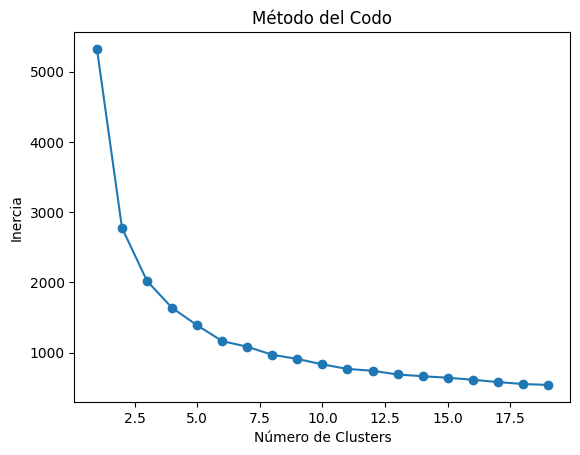

In [167]:
metodo_codo(clientes,20)

En el gráfico se observa una disminución rápida de la inercia al aumentar el número de clústeres, pero esta disminución se estabiliza después de cierto punto. Este "punto de inflexión" o "codo" indica el número óptimo de clústeres

En este caso, el codo parece estar alrededor de 4 o 5 clústeres , ya que después de ese punto, la pendiente se reduce distribuida y la mejora es marginal.

### indice de silueta

El índice de silueta mide qué tan bien se agrupan los puntos en un cluster, teniendo en cuenta tanto la cohesión dentro del cluster como la separación entre clusters. Su rango va de -1 a 1:

- Cercano a 1 : Los puntos están bien agrupados y claramente separados de otros clusters.
- Cercano a 0 : Los puntos están en la frontera entre clusters.
- Cercano a -1 : Los puntos probablemente estén en el grupo equivocado

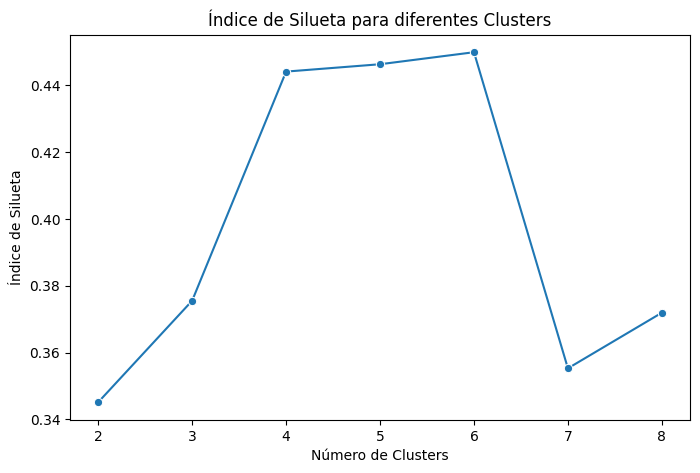

In [168]:
kmeans_con_silueta(df_Minimercado, ['SALES_ORDER_ID', 'QTY', 'PRODUCT_ID'],min_clusters=2, max_clusters=8)

El índice de silueta alcanza su valor máximo para 5 grupos . Esto indica que 5 clusters es el número óptimo según esta métrica, ya que los datos están mejores agrupados en comparación con otros números de clusters.

El índice de silueta disminuye rápidamente después de 6 clusters, Basado en el 5 clusters es el número óptimo para agrupar los datos

### modelo de closter de clientes

In [169]:
modelo_clostering=modelo_kmeans(clientes,6)
centroide_=centroide(clientes,6)

In [170]:
df_Minimercado.reset_index(inplace=True)
modelo_clostering.reset_index(inplace=True)
df_combinado = pd.merge(df_Minimercado, modelo_clostering[['CUSTOMER_ID', 'Cluster']], on='CUSTOMER_ID', how='left')

In [171]:
df_combinado=df_combinado[['ORDER_DATE','Cluster','PRODUCT_ID'\
    ,'QTY','Semana']]

In [172]:
resumen_inicial(df_Minimercado[['ORDER_DATE','CUSTOMER_ID','PRODUCT_ID'\
    ,'QTY','Semana']])

,columns,tipo de dato,categorias
0,ORDER_DATE,object,52
1,CUSTOMER_ID,int64,1775
2,PRODUCT_ID,int64,51
3,QTY,float64,19
4,Semana,int64,9


In [173]:
resumen_inicial(df_combinado)

,columns,tipo de dato,categorias
0,ORDER_DATE,object,52
1,Cluster,int32,6
2,PRODUCT_ID,int64,51
3,QTY,float64,19
4,Semana,int64,9


se paso de 1,175 clientes individuales a 6 clusters , representando grupos con características similares. Esto simplifica significativamente el modelo y permite generalizar patrones en lugar de trabajar de forma individual. sin embargo a un tiene 51 productos distintos , lo que indica una gran diversidad en las preferencias de compra. Esto es un reto, ya que los productos podrían variar significativamente entre clusters.

podemos considerar agrupar también los productos en categorías más amplias para simplificar el análisis.

mañana hacer el mismo procesos pero para los productos y revisar como mejorar la inercia del clostering